In [ ]:
import sys
sys.path.insert(1, './face_parsing')

"""
Face parsing code from:
    https://github.com/zllrunning/face-parsing.PyTorch
    Please download this repo and extract the code to ./3dmm_semantic_parsing/face_parsing/ 
"""
from face_parsing.logger import setup_logger
from face_parsing.model import BiSeNet

import torch

import os
import os.path as osp
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from array import array

import torch.nn as nn
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import torch.nn.functional as F
import pickle
import open3d as o3d
from bfm_model import ReconModel

# Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available')
else:
    device = torch.device("cpu")
    print('CUDA is not available')

In [2]:
## Load the BFM model
import pickle
with open('../BFM/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded')

TAR_SIZE = 512

model = ReconModel(bfm, img_size=TAR_SIZE)
model.train()
model.cuda()

rasterizer = model.rasterizer

BFM model loaded


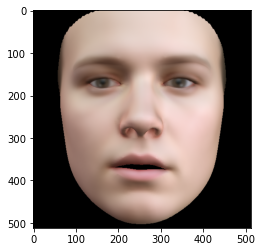

In [4]:
"""example rendering"""

id_tensor = torch.zeros((1, 199), dtype=torch.float32, requires_grad=False, device='cuda')
#id_tensor = torch.tensor(0.5*torch.randn(1, 199), dtype=torch.float32, requires_grad=False, device='cuda')
tex_tensor = torch.zeros((1, 199), dtype=torch.float32, requires_grad=False, device='cuda')
#tex_tensor = torch.tensor(torch.randn(1, 199), dtype=torch.float32, requires_grad=False, device='cuda')
##exp_tensor = torch.zeros((1, 79), dtype=torch.float32, requires_grad=False, device='cuda')
exp_tensor = torch.tensor([[-3.9507e-01, -5.7166e-01, -7.9795e-02,  3.5062e-01,  1.0650e+00,
          2.0101e-01,  1.5081e-01, -5.7472e-01, -8.2971e-01, -4.5539e-01,
          5.5781e-01, -1.6583e-01,  2.2215e-01,  3.6724e-01, -4.0946e-01,
         -1.3894e-02, -5.7202e-01, -4.3365e-01,  5.5339e-04, -2.4644e-01,
         -1.6172e-01,  5.8931e-01, -5.9954e-01,  6.4773e-01, -4.8917e-01,
          1.6858e-01, -2.2301e-01, -6.6901e-01, -4.0780e-01,  2.8299e-01,
          2.1219e-01,  5.9644e-01, -2.0862e-01, -2.7121e-01, -3.1360e-01,
         -5.0774e-02, -3.8371e-01, -6.0954e-01,  3.5723e-01,  4.8921e-01,
          4.1426e-01,  1.7262e-02,  4.7287e-01, -7.5390e-01,  5.7689e-01,
          3.7136e-01, -1.0679e+00, -2.5641e-01,  8.1112e-01, -3.3964e-01,
          8.2755e-01, -3.1114e-01,  9.7300e-01,  5.4294e-02,  2.2442e-02,
         -6.8787e-01,  1.0735e+00, -2.7637e-01,  1.8459e-01,  2.9225e-01,
          1.0279e+00, -7.2293e-01,  7.9839e-01, -2.4782e-01,  7.2635e-01,
          7.6708e-01, -5.8793e-02, -2.3456e-01,  2.0275e-02,  2.4577e-01,
          7.7377e-01, -1.0065e-02, -1.1401e+00,  1.9026e-01,  5.4195e-02,
         -3.5270e-01, -7.2004e-01,  5.7946e-01, -2.3534e-01]], dtype=torch.float32, requires_grad=False, device='cuda')
##exp_tensor = torch.tensor(0.5*torch.randn(1, 79), dtype=torch.float32, requires_grad=False, device='cuda')
gamma_tensor = torch.tensor(
    [[ 0.0973, -0.0762,  0.0636, -0.0572, -0.1019, -0.0760,  0.0040, -0.0672,
      0.1799,  0.1898, -0.0858,  0.0931, -0.0966, -0.1252, -0.1487, -0.0286,
      -0.0650,  0.2028,  0.2721, -0.0592,  0.1335, -0.1047, -0.1249, -0.2317,
      -0.0605, -0.1109,  0.2716]], dtype=torch.float32, requires_grad=False, device='cuda') # pre-fitted SH coefficients
trans_tensor = torch.tensor([[0,0,1.8]], dtype=torch.float32, requires_grad=False, device='cuda')
#trans_tensor = torch.tensor([[0,0,5]], dtype=torch.float32, requires_grad=False, device='cuda')

rot_tensor = torch.tensor([[0,0,0]], dtype=torch.float32, requires_grad=False, device='cuda')

# display rigid fitting result
coeff = torch.cat([id_tensor, exp_tensor,
                    tex_tensor, rot_tensor,
                    gamma_tensor, trans_tensor], dim=1)

def rendering(model, coeff):
    rendered_img, pred_lms, face_texture, mesh = model(coeff)
    rendered_img = rendered_img.detach().cpu().numpy()[0]/255.
    silhouette = np.where(rendered_img[...,3] > 0 , 1., 0.)
    background = 0.*(1 - silhouette)
    rendered_img[...,0] = rendered_img[...,0] + background
    rendered_img[...,1] = rendered_img[...,1] + background
    rendered_img[...,2] = rendered_img[...,2] + background
    rendered_img = rendered_img[...,:3]
    return rendered_img, silhouette, background, mesh

rendered_img, silhouette, background, mesh = rendering(model, coeff)

plt.imshow(rendered_img)

In [4]:
def get_vertex_visibility(rasterizer, mesh):
    """
    Vertex Visibility Map Generation
    Based on: https://github.com/facebookresearch/pytorch3d/issues/126
    """
    # Get the output from rasterization
    fragments = rasterizer(mesh)
    # pix_to_face is of shape (N, H, W, 1)
    pix_to_face = fragments.pix_to_face  
    # (F, 3) where F is the total number of faces across all the meshes in the batch
    packed_faces = mesh.faces_packed() 
    # (V, 3) where V is the total number of verts across all the meshes in the batch
    packed_verts = mesh.verts_packed() 
    visibility_map = torch.zeros(packed_verts.shape[0])   # (V,)
    # Indices of unique visible faces
    visible_faces = pix_to_face.unique()#[0]   # (num_visible_faces )
    # Get Indices of unique visible verts using the vertex indices in the faces
    visible_verts_idx = packed_faces[visible_faces]    # (num_visible_faces,  3)
    unique_visible_verts_idx = torch.unique(visible_verts_idx)   # (num_visible_verts, )
    # Update visibility indicator to 1 for all visible vertices 
    visibility_map[unique_visible_verts_idx] = 1.0
    return visibility_map.detach().cpu().numpy().astype(np.int)


In [5]:
import gc

def run_face_parsing(img, cp):
    n_classes = 19
    net = BiSeNet(n_classes=n_classes)
    net.cuda()
    net.load_state_dict(torch.load(cp))
    net.eval()
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
    with torch.no_grad():
        img = to_tensor(img)
        img = torch.unsqueeze(img, 0)
        img = img.cuda()
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
    gc.collect() # colloct memory
    torch.cuda.empty_cache() # empty cuda
    return parsing


def class_remapping(parsing_mask, silhouette):
    """
    Old Classes:
           2,3: eye brows
           4,5: eyes
            10: nose
        12, 13: lips
    New Classes:
             0: background
             1: face skin
             2: eye brows (left and right eyebrows merged to one class)
             3: eyes (left and right eyes merged to one class)
             4: nose
             5: upper lip
             6: lower lip
    """
    new_mask = np.copy(silhouette).astype(np.int)
    def process(parsing_mask, old_class, new_class):
        one_mask = np.where(parsing_mask == old_class, 1, 0)
        return one_mask, new_class*one_mask
    mapping = {2: 2, 
               3: 2, 
               4: 3, 
               5: 3, 
               10: 4, 
               12: 5, 
               13: 6}
    for old_class in mapping.keys():
        one_mask, class_mask = process(parsing_mask, old_class=old_class, new_class=mapping[old_class])
        new_mask = new_mask * (1 - one_mask) + class_mask    
    return new_mask

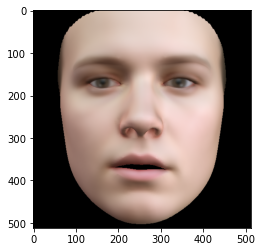

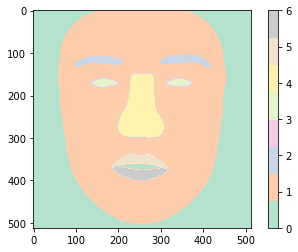

In [195]:
## Example face parsing

parsing_mask = run_face_parsing(rendered_img, cp='./face_parsing/79999_iter.pth')
new_parsing_mask = class_remapping(parsing_mask, silhouette)

# show the rendered 3DMM face
plt.imshow(rendered_img)
plt.show()

# show the corresponding parsing mask
plt.imshow(new_parsing_mask, cmap=plt.get_cmap('Pastel2'))
plt.colorbar()

## Automatic Parsing on 3DMM

  yaw (y-axis) rotation angle range: -0.5 ~ 0.5
  
pitch (x-axis) rotation angle range: -1 ~ 1




In [165]:
def clamp(n, smallest, largest): return max(smallest, min(n, largest))

"""
  Mean shape for various viewing positions
"""
n_vertices = int(model.meanshape.shape[1]/3) # number of vertices
print('Number of vertices: ', n_vertices)

# create a list of baskets to count the amount of class labels for each vertex
baskets = [[] for _ in range(n_vertices)] 

# define the range
yaw_range = [-0.5, 0.5]
pitch_range = [-1, 1]
step_size = 0.1

yaw = yaw_range[0]
while yaw <= yaw_range[1]:
    pitch = pitch_range[0]
    while pitch <= pitch_range[1]:
        ## Generate 3DMM rendered face
        rot_tensor = torch.tensor([[pitch,yaw,0]], dtype=torch.float32, requires_grad=False, device='cuda')
        coeff = torch.cat([id_tensor, exp_tensor,
                    tex_tensor, rot_tensor,
                    gamma_tensor, trans_tensor], dim=1)
        rendered_img, silhouette, background, mesh = rendering(model, coeff)
        
        ## Face parsing on rendered image
        parsing_mask = run_face_parsing(rendered_img, cp='./face_parsing/79999_iter.pth')
        new_parsing_mask = class_remapping(parsing_mask, silhouette)
       
        ## Find each visible vertex's corresponding pixel and class label
        visibility_map = get_vertex_visibility(rasterizer, mesh)
        face_shape_proj = model.forward_shape(coeff).detach().cpu().numpy()[0]
        for i, (x, y) in enumerate(face_shape_proj):
            if visibility_map[i] == 1:
                x = clamp(int(x), 0, TAR_SIZE-1)
                y = clamp(int(y), 0, TAR_SIZE-1)
                label = new_parsing_mask[y,x]
                baskets[i].append(label)
        pitch += step_size
    yaw += step_size
    
print('done!')

Number of vertices:  35709
done!


In [170]:
"""
    Frontal viewing position, random face
    To make lips, eyes, eye brows more accurate
"""

for _ in range(100):
    ## Generate random 3DMM shape
    id_tensor = torch.tensor(0.5*torch.randn(1, 199), dtype=torch.float32, requires_grad=False, device='cuda')
    exp_tensor = torch.tensor(0.5*torch.randn(1, 79), dtype=torch.float32, requires_grad=False, device='cuda')

    ## Generate 3DMM rendered face
    rot_tensor = torch.tensor([[0,0,0]], dtype=torch.float32, requires_grad=False, device='cuda')
    coeff = torch.cat([id_tensor, exp_tensor,
                tex_tensor, rot_tensor,
                gamma_tensor, trans_tensor], dim=1)
    rendered_img, silhouette, background, mesh = rendering(model, coeff)

    ## Face parsing on rendered image
    parsing_mask = run_face_parsing(rendered_img, cp='./face_parsing/79999_iter.pth')
    new_parsing_mask = class_remapping(parsing_mask, silhouette)

    ## Find each visible vertex's corresponding pixel and class label
    visibility_map = get_vertex_visibility(rasterizer, mesh)
    face_shape_proj = model.forward_shape(coeff).detach().cpu().numpy()[0]
    for i, (x, y) in enumerate(face_shape_proj):
        if visibility_map[i] == 1:
            x = clamp(int(x), 0, TAR_SIZE-1)
            y = clamp(int(y), 0, TAR_SIZE-1)
            label = new_parsing_mask[y,x]
            baskets[i].append(label)

print('done!')

c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


done!


In [171]:
def most_frequent(lst):
    return max(set(lst), key = lst.count)

def vote(baskets):
    # get the most counted class label as the vertex label
    vertex_labels = np.zeros([len(baskets)], dtype=np.int)
    for i in range(len(baskets)):
        try:
            vertex_labels[i] = most_frequent(baskets[i])
        except:
            vertex_labels[i] = 0 # basket is empty
            
    return vertex_labels

vertex_labels = vote(baskets)
vertex_labels = np.where(vertex_labels == 0, 1, vertex_labels) # if a vertex is mistakelly classified as background, we change it to skin

# save the vertex-level parsing labels
np.save('./bfm_vertex_labels_automatic_parsing.npy', vertex_labels)

## NOTE: we manually corrected some of the labels using Blender, and saved the the 
## final set of parsing labels to bfm_vertex_labels.npy

The following code is for visualizing the 3DMM parsing result

In [3]:
## load the manually corrected labels
vertex_labels = np.load('../3dmm_local_editing_prototype_1_new/bfm_parsing_correction/bfm_vertex_labels.npy')


In [4]:
def label2color(vertex_labels):
    """
    Convert label to color for visualization
    -----------------------------------------
    0: N/A         --- black   [0,0,0]
    1: face skin   --- green   [0,1,0]
    2: eye brows   --- red     [1,0,0]
    3: eyes        --- blue    [0,0,1]
    4: nose        --- yellow  [1,1,0]
    5: upper lip   --- purple  [1,0,1]
    6: lower lip   --- cyan    [0,1,1]
    """
    mapping = {
        0: np.array([0,0,0]),
        1: np.array([0,1,0]),
        2: np.array([1,0,0]),
        3: np.array([0,0,1]),
        4: np.array([1,1,0]),
        5: np.array([1,0,1]),
        6: np.array([0,1,1])
    }
    colors = np.zeros([len(vertex_labels), 3])
    for i in range(len(vertex_labels)):
        colors[i,:] = mapping[vertex_labels[i]]
    return colors

vertex_colors = label2color(vertex_labels)

In [5]:
V = np.reshape(model.meanshape.detach().cpu().numpy(), [-1, 3])
F = model.tri.detach().cpu().numpy() - 1 ## -1 is critical !!!
T = vertex_colors

#T = np.reshape(model.meantex.detach().cpu().numpy(), [-1,3])/255.

# Open3D mesh normal visualization
o3d_mesh = o3d.geometry.TriangleMesh()
o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
o3d_mesh.triangles = o3d.utility.Vector3iVector(F) # dtype vector3i (int)
o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) 

o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering
o3d.visualization.draw_geometries([o3d_mesh]) # press Ctrl + 9 to see the surface normal

In [241]:
F.shape

(70789, 3)

In [6]:
"""save mesh"""
def save_mesh_as_obj(V, F, T, fname):
    with open(fname, 'w') as file:
        for i in range(len(V)):
            file.write("v {} {} {} ".format(V[i,0],V[i,1],V[i,2]))
            file.write("{} {} {}\n".format(T[i,0],T[i,1],T[i,2]))
        for i in range(len(F)):
            file.write("f {} {} {}\n".format(int(F[i,0]+1),int(F[i,1]+1),int(F[i,2]+1)))
    print('mesh saved!')
    
save_mesh_as_obj(V,F,T,'bfm_mask_corrected.obj')

mesh saved!


In [243]:
"""display loaded mesh"""
loaded_mesh = o3d.io.read_triangle_mesh("bfm_mask.obj")
loaded_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering

o3d.visualization.draw_geometries([loaded_mesh]) 